# Processing Sequences Using RNNs and CNNs

In this chapter we will discuss recurrent neural networks (RNNs), a class of nets that can predict the future (well, up to a point, of course). 

They can analyze time series data such as stock prices, and tell you when to buy or sell. In autonomous driving systems, they can anticipate car trajectories and help avoid accidents. More generally, they can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have considered so far.

For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

## Important Definition Timestep

1) In figure 15-7 of the book, the timestep is X(0), X(1), X(t-1), X(t) which means the network is unrolling through time from left to right. In figure it shows that the network goes from left to right while the input goes from bottom to top in the layers in RNN.
2) For the Batch Normalization with RNNs block in Fighting the Unstable Gradients Problem, the first point that says "Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers." means that you cannot apply BN for the unrolling part that is between X(0) to X(t) but you can only apply for the input that goes from bottom to top in the layers in RNN.

In [1]:
import tensorflow as tf
from tensorflow import keras

## Chapter Content

In this chapter we will first look at the fundamental concepts underlying RNNs and how to train them using backpropagation through time, then we will use them to forecast a time series. After that we’ll explore the two main difficulties that RNNs face:

1) Unstable gradients, which can be alleviated using various techniques, including recurrent dropout and recurrent layer normalization.

2) A (very) limited short-term memory, which can be extended using LSTM and GRU cells.

### RNNs vs CNNs

RNNs are not the only types of neural networks capable of handling sequential data: for small sequences, a regular dense network can do the trick; and for very long sequences, such as audio samples or text, convolutional neural networks can actually work quite well too. We will discuss both of these possibilities, and we will finish this chapter by implementing a WaveNet: this is a CNN architecture capable of handling sequences of tens of thousands of time steps.

 ## Recurrent Neurons and Layers
 

Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward.

A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward.

### RNN example

Let’s look at the simplest possible RNN, it is composed of one neuron receiving inputs, producing an output, and sending that output back to itself.

At each time step t (also called a frame), this recurrent neuron receives the inputs x(t) as well as its own output from the previous time step, y(t–1). Since there is no previous output at the first time step, it is generally set to 0. We can represent this tiny network against the time axis.

This is called unrolling the network through time (it’s the same recurrent neuron represented once per time step). See Fig 15-1 from book

### Creating RNNs

You can easily create a layer of recurrent neurons. At each time step t, every neuron receives both the input vector x(t) and the output vector from the previous time step y(t–1). Note that both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar). See Fig 15-2 from the book.

### Weights and Equations of RNNs

Each recurrent neuron has two sets of weights: one for the inputs x(t) and the other for the outputs of the previous time step, y(t–1). Let’s call these weight vectors wx and wy.

If we consider the whole recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices, Wx and Wy.

The output vector of the whole recurrent layer can then be computed pretty much as you might expect, as shown.(b is the bias vector and ϕ(·) is the activation function (e.g., ReLU))

$$
y_t = \phi(W_x \cdot x_t + W_y \cdot y_{t-1} + b)
$$


Just as with feedforward neural networks, we can compute a recurrent layer’s output in one shot for a whole mini-batch by placing all the inputs at time step t in an input matrix X(t).

$$y_t = 
\phi\left(\begin{bmatrix} X_t & Y_{t-1} \end{bmatrix} W + b\right), \quad \text{where} \quad W = \begin{bmatrix} W_x \\ W_y \end{bmatrix}
$$


#### Equation terms explanation

In this equation:

1) Y(t):- Is an m × n_neurons matrix containing the layer’s outputs at time step t for each instance in the mini-batch (m is the number of instances in the mini-batch and n_neurons is the number of neurons).

2) X(t) :- Is an m × n_inputs matrix containing the inputs for all instances (n_inputs is the number of input features).

3. Wx :- Is an n_inputs × n_neurons matrix containing the connection weights for the inputs of the current time step.

4. Wy :- Is an nneurons × nneurons matrix containing the connection weights for the outputs of the previous time step.

5. b is a vector of size n_neurons containing each neuron’s bias term.

6. The weight matrices Wx and Wy are often concatenated vertically into a single weight matrix W of shape (n_inputs + n_neurons) × n_neurons.

7. The notation [X(t) Y(t–1)] represents the horizontal concatenation of the matrices X(t) and Y(t–1).

#### Y(t)
Notice that Y(t), that is the current output is a function of X(t) and Y(t–1), which is a function of X(t–1) and Y(t–2), which is a function of X(t–2) and Y(t–3), and so on. This makes Y(t) a function of all the inputs since time t = 0 (that is, X(0), X(1), …, X(t) ). At the first time step, t = 0, there are no previous outputs, so they are typically assumed to be all zeros.

## Memory Cells

Since the output of a recurrent neuron at time step t is a function of all the inputs from previous time steps, you could say it has a form of memory. A part of a neural network that preserves some state across time steps is called a memory cell (or simply a cell).

A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task).

### Cell's state

In general a cell’s state at time step t, denoted h(t) (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step: h(t) = f(h(t–1), x(t)).

Its output at time step t, denoted y(t) , is also a function of the previous state and the current inputsf(h(t–1), x(t)). In the case of the basic cells we have discussed so far, the output is simply equal to the state, but in more complex cells this is not always the case. See fig-15-3 in the right side, the hidden state h(0) of neuron x(0) is given as the hidden state for neuron x(1). Hence here the hidden state of neuron x(1) becomes h(0), however, the output computed by x(1) is y(1).

## Input and Output Sequences

### Sequence-to-Sequence

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see the top-left network in Figure 15-4). This type of sequence-to-sequence network is useful for predicting time series such as stock prices: you feed it the prices over the last N days, and it must output the prices shifted by one day into the future (i.e., from N – 1 days ago to tomorrow).

### Sequence-to-Vector network

Alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one (see the top-right network in Figure 15-4). In other words, this is a sequence-to-vector network. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love]).

### Vector-to-Sequence network
Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (see the bottom-left network of Figure 15-4). This is a vector-to-sequence network. For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image.

### Encoder Decoder
Lastly, you could have a sequence-to-vector network, called an encoder, followed by a vector-to-sequence network, called a decoder (see the bottom-right network of Figure 15-4). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an Encoder–Decoder, works much better than trying to translate on the fly with a single sequence-to-sequence RNN (like the one represented at the top left): the last words of a sentence can affect the first words of the translation, so you need to wait until you have seen the whole sentence before translating it.

## Training RNNs

### Backpropagation through time (BPTT)

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation. This strategy is called backpropagation through time (BPTT).

### Training process

Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a cost function C(Y(0), Y(1), …Y(T) ) (where T is the max time step). Note that this cost function may ignore some outputs, as shown in Figure 15-5 (for example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one).

The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows). Finally the model parameters are updated using the gradients computed during BPTT(Note, here BPTT is very similar to normal BP, only difference is that for each error and weight matrix, we also have the historical data, like how Y(current) is the function of previous state and current input) so when BPTT we are updating based on all the timesteps now and not just current).

Note that the gradients flow backward through only the outputs that were used by the cost function, not just through the final output (for example, in Figure 15-5 the cost function is computed using the last three outputs of the network, Y(2), Y(3), and Y(4), so gradients flow through these three outputs, but not through Y(0) and Y(1)). 

Moreover, since the same parameters W and b are used at each time step, backpropagation through time will do the right thing and sum over all time steps.

## Forecasting a Time Series

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step.

This is called a time series. In the first two examples there is a single value per time step, so these are univariate time series, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a multivariate time series.

#### Forecasting and Postdict

A typical task is to predict future values, which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past.This is called $imputation$.

For example, Figure 15-6 shows 3 univariate time series, each of them 50 time steps long, and the goal here is to forecast the value at the next time step (represented by the X) for each of them.

### Generating Time Series

For simplicity, we are using a time series generated by the generate_time_series() function, shown here:

In [2]:
import numpy as np



In [3]:
...

Ellipsis

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

#### generate_time_series function 

This function creates as many time series as requested (via the batch_size argument), each of length n_steps, and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [batch size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

### Note about dimension of time series

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series.

### Creating the Training and Testing Data

Now let’s create a training set, a validation set, and a test set using this function:

In [5]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape # We have 7000 time series, each with 50 timesteps or 50 values

(7000, 50, 1)

In [7]:
X_train[0].shape

(50, 1)

In [8]:
y_train.shape

(7000, 1)

#### Code explanation

X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1]), while X_valid contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000 (from the 9,000th to the 9,999th). Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [9]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02010869

In [10]:
print(X_valid.shape)
X_valid[:, -1].shape

(2000, 50, 1)


(2000, 1)

In [11]:
X_valid[:, -1]

array([[ 0.06317361],
       [ 0.53231114],
       [-0.17881976],
       ...,
       [-0.46301198],
       [ 0.32124105],
       [-0.5564701 ]], dtype=float32)

In [12]:
print(X_valid[0][-1])
print(X_valid[1][-1])
print(X_valid[2][-1])
print(X_valid[1997][-1])
print(X_valid[1998][-1])
print(X_valid[1999][-1])

[0.06317361]
[0.53231114]
[-0.17881976]
[-0.46301198]
[0.32124105]
[-0.5564701]


#### Explanation of slicing in  X_valid[:, -1]

So here in X_valid, we have 2000 time series, each with 50 values or 50 timesteps, now when we do X_valid[:, -1], what we're doing is that we select the last value from the 50 values for each of the 2000 timeseries. This can be verified by checking the above two blocks

### Baseling using Fully connected layer

Another simple approach is to use a fully connected network. Since it expects a flat
list of features for each input, we need to add a Flatten layer. Let’s just use a simple
Linear Regression model so that each prediction will be a linear combination of the
values in the time series:

In [13]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[50, 1]),
 keras.layers.Dense(1)
])

In [14]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))


Epoch 1/20

219/219 [==============================] - 1s 3ms/step - loss: 0.1222 - val_loss: 0.0562
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0243
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0146
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.00

If we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.0037. That’s much better than the naive approach!

In [15]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0036


0.003617848502472043

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

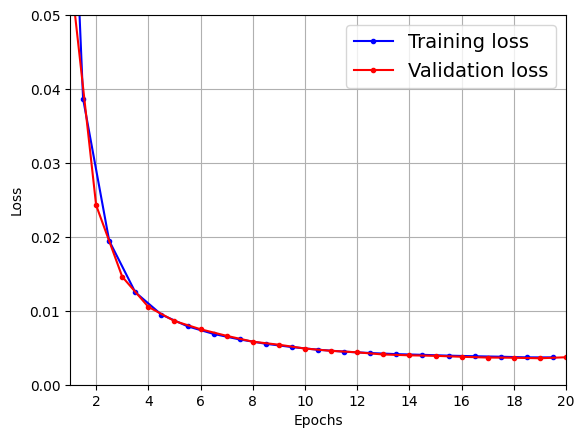

In [17]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Implementing a Simple RNN

Let’s see if we can beat that with a simple RNN:

In [18]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1]) ])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)


history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.4950 - val_loss: 0.2782
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1914 - val_loss: 0.1504
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1483 - val_loss: 0.1540
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1472 - val_loss: 0.1463
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1457 - val_loss: 0.1464
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1458 - val_loss: 0.1345
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0839 - val_loss: 0.0544
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0435 - val_loss: 0.0362
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0318 - val_loss: 0.0282
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0258 - val_loss: 0.0235

In [19]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0112


0.011158519424498081

### Understanding the RNN model

That’s really the simplest RNN you can build. It just contains a single layer, with a single neuron.We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None).

By default, the SimpleRNN layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: the initial state h(init) is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, x(0). 

The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, y0 .

In a simple RNN, this output is also the new state h0. This new state is passed to the same recurrent neuron along with the next input value, x(1), and the process is repeated until the last time step. Then the layer just outputs the last value, y49. All of this is performed simultaneously for every time series.

### Note RNN output
By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True.

#### Conclusion Simple RNN

If you compile, fit, and evaluate this model (just like earlier, we train for 20 epochs using Adam), you will find that its MSE reaches only 0.010, so it is better than the naive approach but it does not beat a simple linear model, where the MSE is 0.0034

Note that for each neuron, a linear model has one parameter per input timestep(that means for every new input, meaning for 50 values there is one parameter and not like for each 50 value there is a parameter, so per input is different from per input value) , plus a bias term (in the simple linear model we used, that’s a total of 51 parameters, since we are inputting 50 timesteps each time).

In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.

### Trend and Seasonality

There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models. Some of them require you to first remove the trend and seasonality. For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. Once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions.


Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called differencing). Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.

When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality.

## Deep RNNs

It is quite common to stack multiple layers of cells. This gives you a deep RNN.

Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers. In this example, we use three SimpleRNN layers (but we could add any other type of recurrent layer, such as an LSTM layer or a GRU layer).

In [20]:
model = keras.models.Sequential([
 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
 keras.layers.SimpleRNN(20, return_sequences=True),
 keras.layers.SimpleRNN(1)
])

### Warning - Defining RNNs
Make sure to set return_sequences=True for all recurrent layers (except the last one if you only want the last output). If you don’t set return_sequences=True, the layers will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

In [21]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.0543 - val_loss: 0.0068
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0034 - val_l

#### This model reaches an MSE of 0.003. We finally managed to beat the linear model!

### RNNs with Dense output layers

Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much.

Moreover, since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if you want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If you make this change, also make sure to remove return_sequences=True from the second (now last) recurrent layer:

In [22]:
model = keras.models.Sequential([
 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
 keras.layers.SimpleRNN(20),
 keras.layers.Dense(1)
])

#### If you train this model, you will see that it converges faster and performs just as well. Plus, you could change the output activation function if you wanted. 

In [23]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0160 - val_loss: 0.0043
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0029 - val_lo

## Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead). But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on, as in the following code.

In [24]:
series = generate_time_series(1, n_steps + 10)
series

array([[[ 0.3802521 ],
        [ 0.23149052],
        [ 0.2192999 ],
        [ 0.06664104],
        [-0.01360943],
        [-0.02652485],
        [-0.11426771],
        [-0.1682559 ],
        [-0.25135887],
        [-0.30491805],
        [-0.42245686],
        [-0.51784587],
        [-0.49846223],
        [-0.4510185 ],
        [-0.31313136],
        [-0.09688105],
        [ 0.18704093],
        [ 0.33760712],
        [ 0.55655795],
        [ 0.6908075 ],
        [ 0.6606459 ],
        [ 0.5541175 ],
        [ 0.42396563],
        [ 0.20434976],
        [-0.03002512],
        [-0.25153124],
        [-0.38200936],
        [-0.5031775 ],
        [-0.49952325],
        [-0.45007983],
        [-0.3745698 ],
        [-0.25856388],
        [-0.2103539 ],
        [-0.12440667],
        [-0.04544733],
        [ 0.03558336],
        [ 0.08591889],
        [ 0.11731767],
        [ 0.30122334],
        [ 0.3689921 ],
        [ 0.49028647],
        [ 0.51113313],
        [ 0.51492333],
        [ 0

In [25]:
series.shape

(1, 60, 1)

In [26]:
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

In [27]:
X_new.shape

(1, 50, 1)

In [28]:
 Y_new.shape

(1, 10, 1)

In [29]:
X = X_new
X_new.shape

(1, 50, 1)

In [30]:
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis] # https://www.reddit.com/r/learnpython/comments/13vs2fu/need_help_to_understand_the_notation_x_npnewaxis/
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 32ms/step


In [31]:
Y_pred.shape

(1, 10, 1)

As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate (as you can see in Figure below).

In [32]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

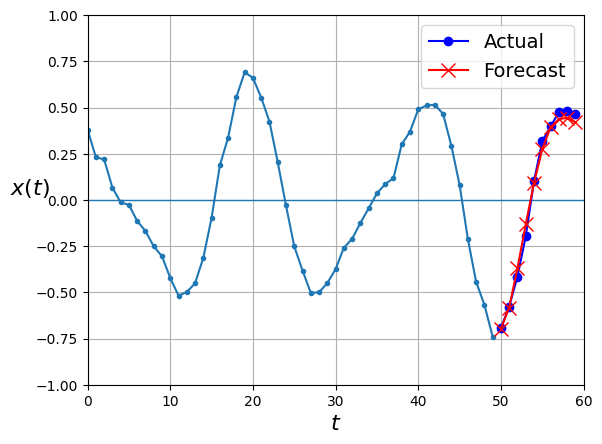

In [33]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [34]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0027


0.002723966259509325

### Building a Sequence to Vector Model

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. However, we first need to change the targets to be vectors containing the next 10 values:

In [35]:
series = generate_time_series(10000, n_steps + 10)
series.shape

(10000, 60, 1)

In [36]:
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]

#### Explanation of above code

For X_train we use normal slicing and get the first 7000 timesteps list, and then for each timestep list we only select the first 50 timesteps

In [37]:
series[3,4,0]

-0.3410013

For y_train what we do can be seen as this series[3,4,0], so if you see what we're doing is selecting the 0th term from the series[3,4] array, and basically reducing the dimensionality of the array from 3 to 2

In [38]:
X_train.shape


(7000, 50, 1)

In [39]:
Y_train.shape

(7000, 10)

In [40]:
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

### Building the Sequence to Vector model

In [41]:
model = keras.models.Sequential([
 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
 keras.layers.SimpleRNN(20),
 keras.layers.Dense(10)
])

In [42]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0619 - val_loss: 0.0346
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0188 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0146 - val_loss: 0.0130
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0119 - val_loss: 0.0133
Epoch 7/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0105 - val_lo

In [43]:
Y_pred = model.predict(X_new)
Y_pred

1/1 [==============================] - 0s 446ms/step


array([[-0.682712  , -0.56280404, -0.4062042 , -0.18403411,  0.02780987,
         0.201294  ,  0.34443343,  0.464635  ,  0.5566441 ,  0.5249793 ]],
      dtype=float32)

This model works nicely: the MSE for the next 10 time steps is about 0.0097. That’s much better than the linear model. But we can still do better: indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step.

In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step, what this means is that the loss will have more terms for the RNN's output. This means there will be many more error gradients flowing through the model; they will also flow from the output of each time step. This will both stabilize and speed up training.

### Building a Sequence to Sequence Model

#### Creating the Targets for the Sequence to Sequence model

In [44]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
Y.shape

(10000, 50, 10)

In [45]:
Y[:,5,:].shape

(10000, 10)

In [46]:
Y[:,:,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
series.shape

(10000, 60, 1)

In [48]:
series[2,3:5]

array([[0.47407362],
       [0.55489206]], dtype=float32)

In [49]:
series[2,3:5,0]

array([0.47407362, 0.55489206], dtype=float32)

In [50]:
series[:, 2:52, 0].shape

(10000, 50)

In [51]:
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

In [52]:
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

### Important!! read below

How Y[:, :, step_ahead - 1] works is that you start with the first column for all the 50 rows in the 1000 timestep list, that means that all the 50 row values for the first column get the data at once. And they get the data from series, where it follows the logic that you get values from 1 to 51 for the 0th timestep and this 0th is of Y , and then 2 to 52 for the 1st timestep and this 1st is of Y and so on.  You can verify using example below

In [53]:
Y[0, :, 0]

array([ 0.1033389 , -0.07078035, -0.31519347, -0.44316781, -0.56059605,
       -0.5022195 , -0.41308492, -0.32441959, -0.3470166 , -0.2889764 ,
       -0.33363661, -0.47243151, -0.51208895, -0.48120731, -0.32930911,
       -0.16255446,  0.03197737,  0.23216781,  0.37547612,  0.43706536,
        0.46103221,  0.4089984 ,  0.28193858,  0.24898152,  0.32530156,
        0.44128111,  0.4607172 ,  0.50861371,  0.56319672,  0.4410986 ,
        0.24593072,  0.08810017, -0.12310109, -0.35903275, -0.38819128,
       -0.41862857, -0.34305269, -0.28082377, -0.23064181, -0.33991426,
       -0.38766631, -0.52408928, -0.58493125, -0.62353468, -0.49672887,
       -0.31832057, -0.1654391 ,  0.08291646,  0.19499661,  0.25814912])

In [54]:
series[0,1:51]

array([[ 0.1033389 ],
       [-0.07078035],
       [-0.31519347],
       [-0.4431678 ],
       [-0.56059605],
       [-0.5022195 ],
       [-0.41308492],
       [-0.3244196 ],
       [-0.3470166 ],
       [-0.2889764 ],
       [-0.3336366 ],
       [-0.4724315 ],
       [-0.51208895],
       [-0.4812073 ],
       [-0.3293091 ],
       [-0.16255446],
       [ 0.03197737],
       [ 0.23216781],
       [ 0.37547612],
       [ 0.43706536],
       [ 0.4610322 ],
       [ 0.4089984 ],
       [ 0.28193858],
       [ 0.24898152],
       [ 0.32530156],
       [ 0.4412811 ],
       [ 0.4607172 ],
       [ 0.5086137 ],
       [ 0.5631967 ],
       [ 0.4410986 ],
       [ 0.24593072],
       [ 0.08810017],
       [-0.12310109],
       [-0.35903275],
       [-0.38819128],
       [-0.41862857],
       [-0.3430527 ],
       [-0.28082377],
       [-0.23064181],
       [-0.33991426],
       [-0.3876663 ],
       [-0.5240893 ],
       [-0.58493125],
       [-0.6235347 ],
       [-0.49672887],
       [-0

### Note Sequence-to-Sequence Model

It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between X_train and Y_train). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a causal model.

To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.

Keras offers a TimeDistributed layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from [batch size, time steps, input dimensions] to [batch size × time steps, input dimensions]; in this example, the number of input dimensions is 20 because the previous SimpleRNN layer has 20 units).

Then it runs the Dense layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from [batch size × time steps, output dimensions] to [batch size, time steps, output dimensions]; in this example the number of output dimensions is 10, since the Dense layer has 10 units). Here is the updated model:

In [55]:
model = keras.models.Sequential([
 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
 keras.layers.SimpleRNN(20, return_sequences=True),
 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

The Dense layer actually supports sequences as inputs (and even higher-dimensional inputs): it handles them just like TimeDistributed(Dense(…)), meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer with just Dense(10). For the sake of clarity, however, we will keep using TimeDistributed(Dense(10)) because it makes it clear that the Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [56]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [57]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [58]:
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])


In [59]:
history = model.fit(X_train, Y_train, epochs=20,validation_data=(X_valid, Y_valid))

Epoch 1/20

219/219 [==============================] - 8s 26ms/step - loss: 0.0499 - last_time_step_mse: 0.0390 - val_loss: 0.0390 - val_last_time_step_mse: 0.0255
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0358 - last_time_step_mse: 0.0230 - val_loss: 0.0330 - val_last_time_step_mse: 0.0201
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0312 - last_time_step_mse: 0.0188 - val_loss: 0.0307 - val_last_time_step_mse: 0.0183
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0276 - last_time_step_mse: 0.0158 - val_loss: 0.0266 - val_last_time_step_mse: 0.0146
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0262 - last_time_step_mse: 0.0148 - val_loss: 0.0260 - val_last_time_step_mse: 0.0144
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0251 - last_time_step_mse: 0.0139 - val_loss: 0.0256 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=

#### We get a validation MSE of about 0.006 for the last_time_step_mse, which is 25% better than the previous model

### Note about forecasting time series

When forecasting time series, it is often useful to have some error bars along with your predictions. For this, an efficient technique is MC Dropout: add an MC Dropout layer
within each memory cell, dropping part of the inputs and hidden states. After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step.

## Handling Long Sequences

To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem. 

## Fighting the Unstable Gradients Problem

Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training.

### Gradient Descent problems with ReLU

1) Suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step.

2) Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that.

3) You can reduce this risk by using a smaller learning rate, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default).

4) In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use Gradient Clipping.

### Batch Normalization with RNNs

1) Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.

2) To be more precise, it is technically possible to add a BN layer to a memory cell (as we will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). 

3) However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results.

### Layer Normalization with RNNs

Another form of normalization often works better with RNNs: Layer Normalization. This idea was introduced by Jimmy Lei Ba et al. It is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension.

One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set.

Like BN, Layer Normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

### Implementing Layer Normalization in RNN using TensorFlow

Let’s use tf.keras to implement Layer Normalization within a simple memory cell.

1) For this, we need to define a custom memory cell. It is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step.

2) Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as we will see shortly).

3) A cell must also have a state_size attribute and an output_size attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:

In [60]:
from tensorflow.keras.layers import LayerNormalization

In [61]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

### Code Explanation

#### Init()

1) Our LNSimpleRNNCell class inherits from the keras.layers.Layer class, just like any custom layer.

2) The constructor takes the number of units and the desired activation function, and it sets the state_size and output_size attributes, then creates a SimpleRNNCell with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function).

3) Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function.

#### Call()

1) The call() method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell, the outputs are just equal to the hidden states: in other words, new_states[0] is equal to outputs, so we can safely ignore new_states in the rest of the call() method).

2) Next, the call() method applies Layer Normalization, followed by the activation function. Finally, it returns the outputs twice (once as the outputs, and once as the new hidden states). To use this custom cell, all we need to do is create a keras.layers.RNN layer, passing it a cell instance:

### Creating the model for Layer Normalization

In [62]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [63]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])


In [64]:
history = model.fit(X_train, Y_train, epochs=20,validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 64ms/step - loss: 0.1421 - last_time_step_mse: 0.1238 - val_loss: 0.0622 - val_last_time_step_mse: 0.0465
Epoch 2/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0549 - last_time_step_mse: 0.0411 - val_loss: 0.0503 - val_last_time_step_mse: 0.0359
Epoch 3/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0462 - last_time_step_mse: 0.0325 - val_loss: 0.0450 - val_last_time_step_mse: 0.0295
Epoch 4/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0408 - last_time_step_mse: 0.0265 - val_loss: 0.0384 - val_last_time_step_mse: 0.0232
Epoch 5/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0359 - last_time_step_mse: 0.0203 - val_loss: 0.0371 - val_last_time_step_mse: 0.0199
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0335 - last_time_step_mse: 0.0168 - val_loss: 0.0331 - val_last_time_step_mse: 0.0169
Epoch 7/20
219/2

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers (except for keras.layers.RNN) and all cells provided by Keras have a dropout hyperparameter and a recurrent_dropout hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). No need to create a custom cell to apply dropout at each time step in an RNN. 

## Tackling the Short-Term Memory Problem

Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper.

To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

## LSTM cells

If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

#### Method 1 for creating an LSTM layer

In [65]:
model = keras.models.Sequential([
 keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
 keras.layers.LSTM(20, return_sequences=True),
 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

#### Method 2 of creating an LSTM layer

Alternatively, you could use the general-purpose keras.layers.RNN layer, giving it an LSTMCell as an argument:

In [66]:
model = keras.models.Sequential([
 keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
 input_shape=[None, 1]),
 keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
 keras.layers.TimeDistributed(keras.layers.Dense(10))
])


In [68]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 40ms/step - loss: 0.0793 - last_time_step_mse: 0.0661 - val_loss: 0.0555 - val_last_time_step_mse: 0.0356
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0483 - last_time_step_mse: 0.0281 - val_loss: 0.0439 - val_last_time_step_mse: 0.0233
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0401 - last_time_step_mse: 0.0193 - val_loss: 0.0378 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0357 - last_time_step_mse: 0.0154 - val_loss: 0.0348 - val_last_time_step_mse: 0.0151
Epoch 5/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0333 - last_time_step_mse: 0.0142 - val_loss: 0.0333 - val_last_time_step_mse: 0.0152
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0317 - last_time_step_mse: 0.0132 - val_loss: 0.0314 - val_last_time_step_mse: 0.0132
Epoch 7/20
219/219 [=

In [69]:

model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0239 - last_time_step_mse: 0.0084


[0.02389674261212349, 0.008444379083812237]

### Working of LSTM cell

LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: h(t) and c(t) (“c” stands for “cell”). You can think of h(t) as the short-term state and c(t) as the long-term state.

#### See figure 15-9 from the book while reading the below explanation

### The Long term state C(t)

The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it. As the long-term state c(t–1) traverses the network from left to right, it first goes through a forget gate, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate). After that, the result c(t) is sent straight out, without any further transformation.

### The Short term state h(t)

After the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate. This produces the short-term state h(t) (which is equal to the cell’s output for this time step, y(t) ).

### Working of the Gates

Now let’s look at where new memories come from and how the gates work.

First, the current input vector x(t) and the previous short-term state h(t–1) are fed to four different fully connected layers(FC in the image). They all serve a different purpose:

#### Main FC Layer outputting g(t)

1) The main layer is the one that outputs g(t). It has the usual role of analyzing the current inputs x(t) and the previous (short-term) state h(t–1).

2) In a basic cell, there is nothing other than this layer, and its output goes straight out to y(t) and h(t). In contrast, in an LSTM cell this layer’s output does not go straight out, but instead its most important parts are stored in the long-term state (and the rest is dropped).

#### Gate Controller layer

The three other layers are gate controllers. Since they use the logistic activation function, their outputs range from 0 to 1. As you can see, their outputs are fed to element-wise multiplication operations, so if they output 0s they close the gate, and if they output 1s they open it.

##### The forget gate f(t)

The forget gate (controlled by f(t)) controls which parts of the long-term state should be erased.

##### The input gate i(t)

The input gate (controlled by i(t)) controls which parts of g(t)should be added to the long-term state.

##### The output gate o(t)

Finally, the output gate (controlled by o(t)) controls which parts of the longterm state should be read and output at this time step, both to h(t) and to y(t).

### VVV IMP!!! See equation 15-3 from the book

### Conclusion LSTM

In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

### Peephole connections

In a regular LSTM cell, the gate controllers can look only at the input x(t) and the previous short-term state h(t–1). It may be a good idea to give them a bit more context by letting them peek at the long-term state as well. This idea was proposed by Felix Gersand Jürgen Schmidhuber in 2000.

They proposed an LSTM variant with extra connections called peephole connections: the previous long-term state c(t–1) is added as an input to the controllers of the forget gate and the input gate, and the current longterm state c(t) is added as input to the controller of the output gate.

This often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them: you will have to try it on your task and see if it helps.

In Keras, the LSTM layer is based on the keras.layers.LSTMCell cell, which does not support peepholes. The experimental tf.keras.experimental.PeepholeLSTMCell does, however, so you can create a keras.layers.RNN layer and pass a PeepholeLSTM Cell to its constructor. 

## GRU cell

The Gated Recurrent Unit (GRU) cell was proposed by Kyunghyun Cho et al.

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well. These are the main simplifications:

In [70]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 40ms/step - loss: 0.0751 - last_time_step_mse: 0.0677 - val_loss: 0.0541 - val_last_time_step_mse: 0.0424
Epoch 2/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0487 - last_time_step_mse: 0.0386 - val_loss: 0.0468 - val_last_time_step_mse: 0.0369
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0437 - last_time_step_mse: 0.0332 - val_loss: 0.0423 - val_last_time_step_mse: 0.0307
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0398 - last_time_step_mse: 0.0288 - val_loss: 0.0384 - val_last_time_step_mse: 0.0267
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0363 - last_time_step_mse: 0.0252 - val_loss: 0.0358 - val_last_time_step_mse: 0.0234
Epoch 6/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0338 - last_time_step_mse: 0.0219 - val_loss: 0.0334 - val_last_time_step_mse: 0.0207
Epoch 7/20
219/219 [=

In [71]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0242 - last_time_step_mse: 0.0103


[0.024223146960139275, 0.010310187935829163]

#### See figure 15-10 from the book while reading the below explanation

1) Both state vectors are merged into a single vector h(t).

2) A single gate controller z(t) controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first.

3) There is no output gate; the full state vector is output at every time step. However, there is a new gate controller r(t) that controls which part of the previous state will be shown to the main layer (g(t)).

Keras provides a keras.layers.GRU layer (based on the keras.layers.GRUCell memory cell); using it is just a matter of replacing SimpleRNN or LSTM with GRU.

### VVV IMP!!! See equation 15-4 from the book

## Solving Long Sequences problem

### Using 1D convolutional layers to process sequences.

In CNNs, we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size).

If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10-dimensional sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers).

If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly.

### Implementing CNNs with GRU

The following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details.

By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3, and since we've seen that in case of RNN the hidden state for the first run is set to 0, and if we don't do this then the LSTM will get 0 as the input for the hidden state.), and downsample the targets by a factor of 2(downsample basically means select only every second target value from the columns).

In [72]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 25ms/step - loss: 0.0692 - last_time_step_mse: 0.0613 - val_loss: 0.0482 - val_last_time_step_mse: 0.0380
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0412 - last_time_step_mse: 0.0333 - val_loss: 0.0366 - val_last_time_step_mse: 0.0271
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0305 - last_time_step_mse: 0.0206 - val_loss: 0.0276 - val_last_time_step_mse: 0.0161
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0256 - last_time_step_mse: 0.0144 - val_loss: 0.0250 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0240 - last_time_step_mse: 0.0130 - val_loss: 0.0238 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0229 - last_time_step_mse: 0.0121 - val_loss: 0.0231 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/219 [==

In [76]:
Y_valid[0]

array([[-0.31480166, -0.35355434, -0.44950873, -0.4210304 , -0.41469261,
        -0.34517896, -0.1852376 ,  0.05097008,  0.35469484,  0.53110516],
       [-0.35355434, -0.44950873, -0.4210304 , -0.41469261, -0.34517896,
        -0.1852376 ,  0.05097008,  0.35469484,  0.53110516,  0.60427958],
       [-0.44950873, -0.4210304 , -0.41469261, -0.34517896, -0.1852376 ,
         0.05097008,  0.35469484,  0.53110516,  0.60427958,  0.57887834],
       [-0.4210304 , -0.41469261, -0.34517896, -0.1852376 ,  0.05097008,
         0.35469484,  0.53110516,  0.60427958,  0.57887834,  0.44205871],
       [-0.41469261, -0.34517896, -0.1852376 ,  0.05097008,  0.35469484,
         0.53110516,  0.60427958,  0.57887834,  0.44205871,  0.32154039],
       [-0.34517896, -0.1852376 ,  0.05097008,  0.35469484,  0.53110516,
         0.60427958,  0.57887834,  0.44205871,  0.32154039,  0.23079869],
       [-0.1852376 ,  0.05097008,  0.35469484,  0.53110516,  0.60427958,
         0.57887834,  0.44205871,  0.32154039

## WaveNet

In a 2016 paper, Aaron van den Oord and other DeepMind researchers introduced an architecture called WaveNet. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11).

This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

### WaveNet architecture

In the WaveNet paper, the authors actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers.

They justified this architecture by pointing out that a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024 (except way faster, more powerful, and using significantly fewer parameters), which is why they stacked 3 such blocks.

They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network (this is done by passing padding = 'casual').

### Implementing WaveNet

In [77]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20,validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0627 - last_time_step_mse: 0.0507 - val_loss: 0.0369 - val_last_time_step_mse: 0.0219
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0321 - last_time_step_mse: 0.0183 - val_loss: 0.0312 - val_last_time_step_mse: 0.0182
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0284 - last_time_step_mse: 0.0155 - val_loss: 0.0279 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0265 - last_time_step_mse: 0.0139 - val_loss: 0.0267 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0251 - last_time_step_mse: 0.0128 - val_loss: 0.0256 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0243 - last_time_step_mse: 0.0122 - val_loss: 0.0248 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/219 [==

### Code Explanation

This Sequential model starts with an explicit input layer (this is simpler than trying to set input_shape only on the first layer), then continues with a 1D convolutional layer using "causal" padding: this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using "valid" padding).

We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8.

Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function. Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them.

In the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages. They also used the model to generate music, one audio sample at a time. This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps—even LSTMs and GRUs cannot handle such long sequences.

In [79]:
for ki  in (1,2,3,4) * 2:
    print(ki)

1
2
3
4
1
2
3
4
